# Does Weather has an significant impact on the number of highway

traffic accidents?

Felix Büppelmann  
2023-06-10

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_sql_table('weatherCrashData', 'sqlite:///final_report_data.sqlite')

def locationMap(df, color, title, zoom=5):
  fig = px.scatter_mapbox(df, lat="Latitude", 
  lon="Longitude", 
  color=color,  
  size_max=8,
  zoom=zoom,
  height=500,
  hover_data={'Latitude': False, 'Longitude': False, 'Strecke': True, 'Kilometer': True},
  center={'lat': df['Latitude'].mean(), 'lon': df['Longitude'].mean()})
  fig.update_layout(mapbox_style="outdoors", mapbox_accesstoken="pk.eyJ1IjoibGlmZW9mZmVsaXh0IiwiYSI6ImNsaXQ2aHB6ZzBsc2ozcW96MjdvZmc3azIifQ.N5nMWySGLLJcjh0Ha1e9CA")
  fig.update_layout(title_text=title, title_x=0.5)
  return fig

def densityMap(df, z, title):
  fig = px.density_mapbox(df, lat="Latitude", 
  lon="Longitude",  
  z=z, 
  radius=3,
  zoom=4,
  height=500,
  hover_data={'Latitude': False, 'Longitude': False, 'Strecke': True, 'Kilometer': True},
  center={'lat': df['Latitude'].mean(), 'lon': df['Longitude'].mean()})
  #fig.update_layout(mapbox_style='stamen-toner')
  fig.update_layout(mapbox_style="outdoors", mapbox_accesstoken="pk.eyJ1IjoibGlmZW9mZmVsaXh0IiwiYSI6ImNsaXQ2aHB6ZzBsc2ozcW96MjdvZmc3azIifQ.N5nMWySGLLJcjh0Ha1e9CA")
  fig.update_layout(title_text=title, title_x=0.5)
  return fig

if not os.path.exists("images"):
    os.mkdir("images")

## Summary

Analysis of weather events on German highways and accidents in 2018-19.

## Rationale

It analyses whether highway segments that are particularly exposed to
extreme weather events result in more car crashes than usual.

## Datasources

### Highway Weather Data

-   Metadata: [URL](https://mobilithek.info/offers/-3534538293975156153)
-   Data:
    [URL](https://www.mcloud.de/downloads/mcloud/96EA9CD1-0695-4461-90B1-BC6F6B0E0729/%3EResultat_HotSpot_Analyse_neu.csv)
-   Data Type: CSV
-   Description: Weather events on specific routes were studied using
    reanalysis data from all of Germany from Dec. 1, 2017-Nov. 30, 2019.
    The weather values of 3160 points with 1 km distance were read from
    the data and averaged or summed up, depending on the parameter. The
    values were normalized and the highest was given the value 100, the
    lowest the value 0.

### CrashData

-   Metadata:
    [URL](https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/)
-   Data:
    [2017](https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/Unfallorte2017_EPSG25832_CSV.zip)
    [2018](https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/Unfallorte2018_EPSG25832_CSV.zip)
    [2019](https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/Unfallorte2019_EPSG25832_CSV.zip)
-   Data Type: ZIP/CSV
-   Description: Road traffic accident data of 2017 to 2019 of Germany.

## Transformations

1.  Preporcessing of the weather data
    -   Give each weather measure point a unique ID
    -   As the measure points are distributed one kilometer apart from
        each other, each points gets an kilomter marker
2.  Preprocessing of the crash data
    -   Dropping rows with irrelevant data (turn accidents, bike
        accidents, etc.)
    -   Drop columns with irrelevant data
3.  Connect the crash data with the weather data
    -   For each crash, find the closest weather measure point
        (Treshold: 600m)
        -   Drop rows where no point is within the treshold
        -   If there are multiple points within the treshold, select the
            one closest
    -   Merge crash data to the weather data
4.  Normalize the combined data per Route

## Analysis

During the first analysis all routes are looked at. The first map shows
the location of the routes. The second map shows the number of crashes
per kilometer normalized. The third map shows the normalized weather
events per kilometer. The higher the number the more and severe weather
events occured.

In [2]:
fig_1 = locationMap(data, 'Strecke', 'Map of all the routes', zoom=4)
fig_1.show()
fig_1.write_image("images/Strecke.png")

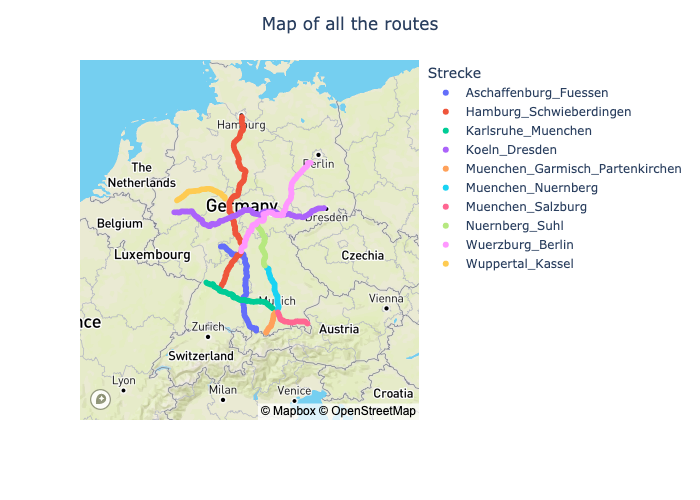

In [3]:
fig_2 = densityMap(data, 'NormalizedCrash', 'Map of all the crashes along the routes')
fig_3 = densityMap(data, 'Gesamt', 'Map of the weather events combined along the routes')
fig_2.show()
fig_3.show()

It can be seen that the number of crashes is higher in the south of
Germany. The weather events are also more severe in the south. My
hypothesis is that the weather events have an impact on the number of
crashes. Therefore a correlation analysis is performed.

#### Correlation Analysis

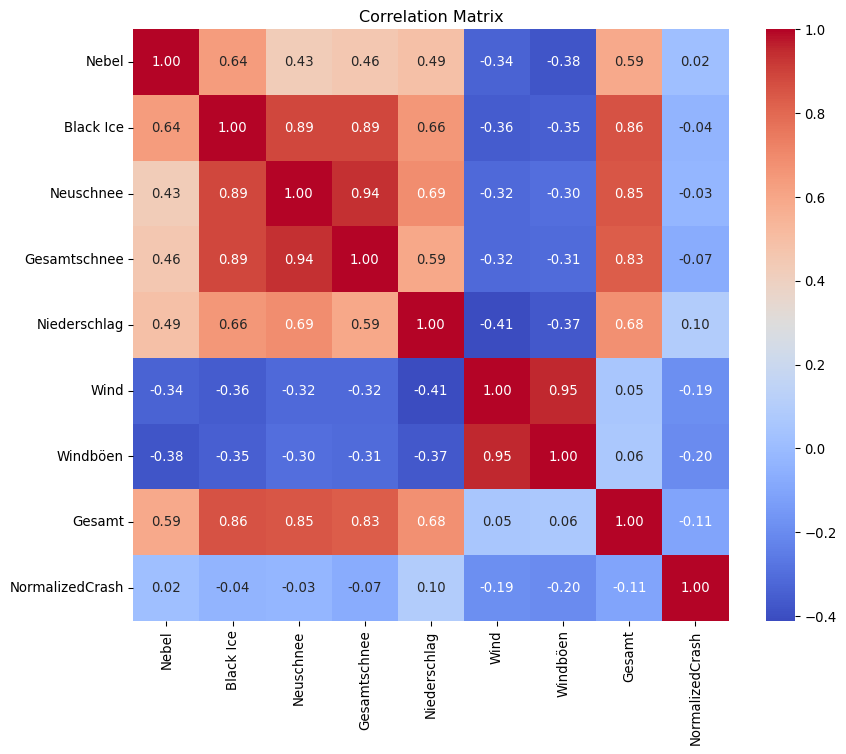

In [4]:
# List of columns to exclude from correlation calculation
columns_to_exclude = ['index','Strecke', 'StreckeID', 'Kilometer', 'Count', 'CrashCount', 'CrashCountWet', 'CrashCountSnow', 'CrashCountWetSnow','Latitude', 'Longitude', 'NormalizedCrashWet', 'NormalizedCrashSnow', 'NormalizedCrashWetSnow']  # Add the column names you want to exclude

# Select only the columns of interest
selected_columns = [col for col in data.columns if col not in columns_to_exclude]

# Calculate the correlation matrix
corr_matrix = data[selected_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows that there are following weather events
that have a high correlation with the number of crashes:

In [5]:
# Find the column(s) with the highest correlation coefficient(s)
highest_corr = corr_matrix['NormalizedCrash'].abs().nlargest(5)  # Change 'CarCrashes' to your actual car crash column name
top_weather_phenomena = highest_corr.index[1:]  # Exclude 'CarCrashes' itself if present
top_weather_phenomena

Index(['Windböen', 'Wind', 'Gesamt', 'Niederschlag'], dtype='object')

It is interesting that the number of crashes is not strongly correlated
with the number of weather events. Further it is interesting that the
top correlated weather events are ‘Windböen’ and ‘Wind’ which are both
related to wind, and these are correlated negativly. Which means that
the more wind there is on a highway, the less crashes happen. This is
counterintuitive. One possible reason for that is that people drive more
carefully when there is more wind, but this is speculation.

The only positive correlation is with ‘Niederschlag’ which means that
the more precipitation there is, the more crashes happen. This seams
reasonable. To explore this further the data is filtered for crashes
that happened during or due to precipitation.

#### Analysis of crashes during precipitation

In [6]:
fig_4 = densityMap(data, 'NormalizedCrashWet', 'Map of all the crashes in the Wet along the routes')
fig_4.show()